In [2]:
from IPython.core.display import HTML, Image, display
custom_style_file = 'styles/ricardo_stylesheet.css' # or the path to the style sheet
styles = open(custom_style_file, 'r').read()
HTML(styles)

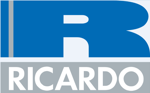

In [34]:
Image(filename = 'styles/ricardo_logo.png', width = 80, embed = True)

<hr>

# Introduction to creating dashboards with notebooks

## Intro 

The `Plotly` library is a great way of creating interactive reports within Jupyter Notebooks. 

If you haven't followed the previous tutorials on setting up your notebooks, find them here: https://github.com/genagibson/ricardo_template_style



In [3]:
display(HTML('''<div class = "commenter1"> 
    <b>Good practice:</b> Quality checks are important for any kind of deliverable, including code. 
    Please make sure you're getting your code reviewed.
</div>'''))

## Set up

The basic libraries you will need to include interactive reporting are included in the import statements below. As ever, if you are missing a library you can install it with pip. 

In [3]:
import os

# Numerical python
import numpy as np
import pandas as pd

# iPython display
from IPython.core.display import HTML, Image, display

# Static plotting
import matplotlib.pyplot as plt
%matplotlib inline 
plt.style.use('seaborn-white')

import seaborn as sns

# Interactive plotting
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode(connected=True)

# Other Helpful fucntions
import itertools
import warnings

### Other libraries

We can use notebooks to create simple report-like dashboards. The layouts are somewhat restricted by the linear display of the cells, and there doesn't seem to be a way around this at the time of writing. 

A number of options are available to create dashboards, but at this point in time, most of them cannot be exported to html (although this may change in time). The options that cannot be exported include:
* Dash
* ipywidgets and figure widgets
* Dashboard extension to jupyter

Deploying to a server is much more complicated, and any external-facing website would require involvement from our digital services team, adding significantly to the cost and time taken. 

Instead, it is recommended to keep within the notebook format. In most cases this should be sufficient, but it is important to ensure that the proposal does not over-promise. 

### Import data

Let's start with a built-in dataset. 

In [4]:
df = sns.load_dataset('iris')
df.head().style.set_caption('Example data from the iris dataframe')

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5,3.6,1.4,0.2,setosa


## Plotting overview

### Simple plot

We have our simple graph that comes with standard Plotly interactivity: zoom, pan, select etc. 

In [5]:
# Universal settings
marker_size = 10
opacity = 0.5

In [6]:
x = df['sepal_length']
y = df['sepal_width']

display(HTML('<figcaption> Plotly graph </figcaption>'))

trace = go.Scatter(
    mode = 'markers',
    x = list(x),
    y = list(y),
    marker = dict(size = marker_size, 
                 opacity = opacity)
)

data = [trace]
layout = go.Layout(
    xaxis = dict(title = 'sepal_length'),
    yaxis = dict(title = 'sepal_width')
)

fig = dict(data = data,
             layout = layout);
plotly.offline.iplot(fig);

This works, but it's a pretty manual process. For use in any serious report, we'll need to improve it. 

In [7]:
display(HTML('''<div class = "commenter1"> 
    <b>Good practice:</b> The whole point of doing things in Python is to reduce the amount of repetitive work. <br>
    If you find yourself typing something manually more than once, it's time to create a function.
</div>'''))

## Using loops for categorical variables

First, let's make a custom function that creates a graph of any two variables. This is already an improvement when we're trying to create a lot of graphs...

The function below is very similar to the manually-typed way of creating a plot, but it hides all of the additional text in a function so that you only need to input the variables to use for x and y.

In [8]:
# Create a list of the numerical variables in the dataset (excluding species)
variable_list = list(df)[:4] 
variable_list

['sepal_length', 'sepal_width', 'petal_length', 'petal_width']

In [9]:
def plot_any(x, y, mode = 'markers'):
    ''' This function creates a plotly figure object for a given x and y 
    Params:
        x: parameter to be plotted on the x axis
        y: parameter to be plotted on the y axis
        
    Returns:
        fig object that can be plotted directly or saved
    
    '''
    # Updates the x and y traces according to the input
    trace = go.Scatter(
        mode = mode,
        x = list(df[x]),
        y = list(df[y]),
        marker = dict(size = marker_size, 
                     opacity = opacity)
    )

    data = [trace]
    layout = go.Layout(
        xaxis = dict(title = str(x)),
        yaxis = dict(title = str(y))
    )

    fig = dict(data = data,
                 layout = layout);
    return fig # Saves to a fig variable, but does not plot it yet

In [10]:
display(HTML('''<div class = "commenter1"> 
    <b>Good practice:</b> it's important to include docstrings for every function you create. 
    This is the text included in triple quotes at the start of the function. <br>
    The first line gives a short explanation of the function <br>
    "Params" lists the input parameters <br>
    "Returns" lists what the function returns
</div>'''))


Why am I going to insist that you include docstrings? So many reasons! But mainly it helps to understand what you meant the function to do so that bugs can be spotted. It's also super useful when you're reusing the function later on... type in the function name and hit tab, and you'll see a helpful reminder of what the inputs and outputs should be. 

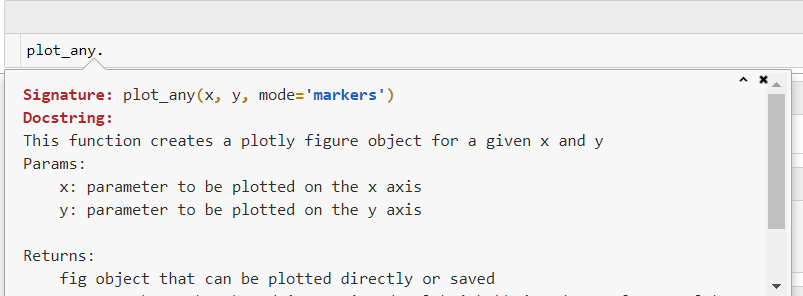

In [33]:
display(HTML('<figcaption> Press shift + tab to see the docstring </figcaption>'))
Image(filename = 'files/pictures/docstrings.PNG', width = 700, embed = True)

Let's test out the new function.

In [11]:
# Choose any x and y
x = 'petal_length'
y = 'petal_width'

In [12]:
fig = plot_any(x, y)
display(HTML('<figcaption> Plotly graph </figcaption>'))
plotly.offline.iplot(fig);

Great - we can create any graph in this format with just 3 lines of code. The `markers` argument is optional, and will default to a scatter plot if we just leave it out, as done here. 

### Create traces using a loop

When we want to have interactive plotting on the graph, the traces need to be loaded up in advance. 
We can edit the function to plot the traces that we want, and store them in a list. 

In [13]:
# We can get a list of the unique values of any column using unique()
subset_list = df['species'].unique()
subset_list

array(['setosa', 'versicolor', 'virginica'], dtype=object)

In [14]:
def make_traces_by_category(x, y, categorical_column, mode = 'markers'):
    ''' Makes a list of traces, one for each category in the categorical column
    Params:
        x: parameter to be plotted on the x axis
        y: parameter to be plotted on the y axis
        categorical_column: categories to be shown in different colours
        mode: optional setting to change the type of chart
        
    Returns:
        fig object that can be plotted directly or saved
    '''
    trace_list = []
    
    # Create a list of the unique values
    subset_list = df[categorical_column].unique()
    
    # Get the trace for the subset
    for each in subset_list:
        trace = go.Scatter(
            mode = mode,
            x = list(df.loc[df[categorical_column] == each][x]), # Subsets the dataframe by the category
            y = list(df.loc[df[categorical_column] == each][y]),
            
            marker = dict(size = marker_size, 
                         opacity = opacity),
            name = str(each) # Assigns a name to each trace for use in the legend
        )
        
        trace_list.append(trace)
    
    return trace_list
        

Let's apply `make_traces_by_category` to the iris dataset, using species as the categorical column. We can see that the length of `trace_list` is 3: one for each species.  

You can customise the traces a lot yourself - this version uses the defaults for most settings. 

In [15]:
trace_list = make_traces_by_category(x, y, 'species')
len(trace_list)

3

### Putting it all together

Now let's put it all together into a single function that plots everything for us in one go. 

In [16]:
def plot_categorical(x, y, categorical_column, mode = 'markers'):
    ''' Makes a figure with interactive selection of different categories
    Params:
        x: parameter to be plotted on the x axis
        y: parameter to be plotted on the y axis
        categorical_column: categories to be shown in different colours
        mode: optional setting to change the type of chart
        
    Returns:
        trace_list: list of traces in plotly format
    '''
    layout = go.Layout(
        xaxis = dict(title = x),
        yaxis = dict(title = y)
    )

    trace_list = make_traces_by_category(x, y, categorical_column) # Calls the make_traces function within this wrapper
    fig = dict(data = trace_list,
              layout = layout);
    return fig

It's now possible to select the different categories of species by clicking the legend to turn them on and off. 
You'll find that the graphs quickly become cluttered if you leave the `hoverinfo` parameters as their defaults, so this will probably be something you customise early on. 

In [17]:
fig = plot_categorical(x, y, 'species')
display(HTML('<figcaption> Graph with option to select and de-select categories </figcaption>'))
plotly.offline.iplot(fig);

And we can easily change the chart by editing the values of x and y. Let's change them to `sepal_length` and `sepal_width` below. 

In [18]:
fig = plot_categorical('sepal_length', 'sepal_width', 'species')
display(HTML('<figcaption> Graph with option to select and de-select categories </figcaption>'))
plotly.offline.iplot(fig);

## Controlling charts using toggle buttons

Buttons can be used to update both chart layouts and data attributes. 

### Automate the generation of the buttons
The information for the toggle buttons is contained in a dictionary. In this case we will toggle visibility for the difference traces in order to update the charts. This is done by using the `truth` list for each button.

In [21]:
def make_buttons(variable_list):
    button_list = []   
    
    # Create buttons
    for index, item in enumerate(variable_list):
        # Initialise blank dictionary
        button_dict = {}
        button_dict['label'] = str(item) # Label for the button
        button_dict['method'] = 'update' # Assign the update method 
        
        # Initialise visibility a list
        truth = [False]*len(variable_list)
        truth[index] = True # This changes one element of the list to True, in order to show the right trace
        button_dict['args'] = [
            {'visible': truth},
            {'yaxis': dict(title = str(item))} # Update y axis label to match what is showing
                              ]
        
        button_list.append(button_dict)
    return button_list

We can see the difference between the two buttons is in the labels, as well as the position of 'True' in the 'visible' list. 

In [22]:
button_list = make_buttons(list(df)[:4])

# Let's look at the first button
button_list[0]

{'label': 'sepal_length',
 'method': 'update',
 'args': [{'visible': [True, False, False, False]},
  {'yaxis': {'title': 'sepal_length'}}]}

In [23]:
# And the second
button_list[1]

{'label': 'sepal_width',
 'method': 'update',
 'args': [{'visible': [False, True, False, False]},
  {'yaxis': {'title': 'sepal_width'}}]}

### Using buttons to update the charts

Let's simplify the graph and get rid of the different colours by category. We still want a loop to generate the traces for us - example code is in the make_simple_traces function. 


In [24]:
def make_simple_traces(x, y_list, mode = 'markers'):
    ''' Makes a list of traces 
    Params:
        x: parameter to be plotted on the x axis
        y_list: list of parameters to be plotted on the y axis
        mode: optional setting to change the type of chart
        
    Returns:
        trace_list for incorporation into figures
    '''
    trace_list = []
    
    # Get the trace for the subset
    for index, item in enumerate(y_list):
        # Set default visibility to be true for the first trace
        if index == 0:
                visible = True
        else:
            visible = False
            
        # Create traces
        trace = go.Scatter(
            mode = mode,
            x = list(df[x]), # Subsets the dataframe by the category
            y = list(df[item]),
            
            marker = dict(size = marker_size, 
                         opacity = opacity),
            name = str(item),
            visible = visible # if else can't be used with go.Scatter, so these need to be done first and assigned here
        )
        
        trace_list.append(trace)
    
    return trace_list
        

We could then create a wrapper that uses this as a building block to generate a graph, and following all of the good practices mentioned above. 

In [25]:
def make_toggle_plot(x, y_list):
    
    trace_list = make_simple_traces(x, y_list)  # calls the function defined above

    # This allows us to the buttons to the graph and indicates that we want them to update the data display
    updatemenus = list([
        dict(type = 'buttons', 
             active = 1,
            buttons = button_list)

    ])

    layout = go.Layout(
        xaxis = dict(title = str(x)), # Let's keep the x variable fixed
        showlegend = False, # Remove legend
        updatemenus = updatemenus
    )

    fig = dict(data = trace_list,
              layout = layout);
    
    return fig


In [26]:
fig = make_toggle_plot(x, list(df)[:4])
display(HTML('<figcaption> Graph with toggle buttons </figcaption>'))
plotly.offline.iplot(fig);

Hopefully this has shown how you can build up functions to achieve different types of graphs, and save you the pain of trying to edit things manually. 

In [27]:
display(HTML('''
<hr> 
<div class = 'footnote'>
Contact gena.gibson@ricardo.com for suggestions <br>
Version last updated on 20 July 2019
</div>'''))